In [1]:
#!pip uninstall statsmodels
#y


In [2]:
#pip install git+https://github.com/statsmodels/statsmodels

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import pywt

from itertools import islice
from collections import deque

from tensorflow.python.keras.layers import Input, Dense,RNN,LSTMCell
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.losses import mean_absolute_percentage_error,mae

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa import statespace

from pandas.plotting import autocorrelation_plot

from datetime import datetime
from sklearn.metrics import classification_report,confusion_matrix

In [4]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

def mae(A,F):
    return np.mean(np.abs(A -F))

def get_family(wave):
  if 'bior' in wave:
    return 'bior'
  elif 'coif' in wave:
    return 'coif'
  elif 'db' in wave:
    return 'db'
  elif 'dmey' in wave:
    return 'dmey'
  elif 'rbio' in wave:
    return 'rbio'
  elif 'sym' in wave:
    return 'sym'
  else:
    return 'haar'

def denoise(original,WAVELET):

  signal = original.values

  coeffs = pywt.wavedec(signal, WAVELET)
  coeffs[1:] = (pywt.threshold(detail,
                              value=0.5 * np.std(detail), 
                              mode="soft" ) for detail in coeffs[1:])
  reconstructed_signal = pywt.waverec(coeffs, WAVELET)
  return pd.Series(reconstructed_signal[:-1],index=original.index)


def window(seq, n=4):
  it = iter(seq)
  result = tuple(islice(it, n))
  if len(result) == n:
    yield np.array(result)
  for elem in it:
    result = result[1:] + (elem,)
    yield np.array(result)


In [5]:
def percentage_scaler(signal,low=0,high=100):
  minV = np.min(signal)
  maxV = np.max(signal)
  denom = maxV - minV

  scaled_signal = low + ((signal - minV )* (high-low)) / denom 

  return round(scaled_signal)

def get_label(x):
  if x == 0.0:
    return 'ZERO'
  elif x < SCALE_UP_WATER_MARK:
    return 'STAY'
  else :
    return 'SCALE UP'

In [32]:
SCALE_UP_WATER_MARK = 8

In [7]:
df = pd.read_csv('winProxy.csv',parse_dates=True,index_col=0)
original = df.CPU
df['smooth_CPU'] = denoise(original,'db38')

df.diskwrite = df.diskwrite.shift(periods=1)
df.diskwrite = df.diskwrite.fillna(0)
#df[["CPU","diskwrite"]].tail()

df.IOBalance = df.IOBalance.shift(periods=1)
df.IOBalance = df.IOBalance.fillna(0)



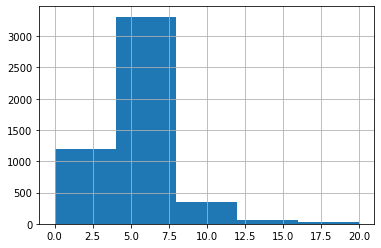

In [56]:
#time_index = pd.date_range(start='2020-06-01T00:00:00',end='2020-07-16T00:00:00',freq='5T')
#df.index = time_index

df[(df.CPU != 0.0) & (df.CPU < 20)].CPU.hist(bins=5,range=(0,20))
plt.show()

# RW

In [9]:
train_size = round(len(df) * 0.8)

Y_test = original[train_size:].values

rw_forecast = ((original[train_size-1:]).shift(1)[1:]).values

In [10]:
print("MAPE : ",mape(Y_test+1,rw_forecast+1))
print("SMAPE : ",smape(Y_test+1,rw_forecast+1))
print("MAE : ",mae(Y_test+1,rw_forecast+1))

MAPE :  6.67908647322508
SMAPE :  4.328813232318384
MAE :  0.3488425925925926


In [33]:
Y_test_labels = [get_label(x) for x in Y_test]
rw_test_labels = [get_label(x) for x in rw_forecast]

print(classification_report(Y_test_labels,rw_test_labels))
confusion_matrix(Y_test_labels,rw_test_labels)

              precision    recall  f1-score   support

    SCALE UP       0.30      0.30      0.30        30
        STAY       0.97      0.97      0.97       745
        ZERO       1.00      0.99      0.99      1817

    accuracy                           0.98      2592
   macro avg       0.75      0.75      0.75      2592
weighted avg       0.98      0.98      0.98      2592



array([[   9,   15,    6],
       [  21,  721,    3],
       [   0,   10, 1807]])

# AR

In [12]:
'''ma_forecast = []
training_endog = df.CPU[:train_size]
mod = sm.tsa.statespace.SARIMAX(df.CPU[:train_size], 
                          order=(4,0,0),freq='5T')
                          #exog = train.diskwrite.values  )
                          #seasonal_order=(0,1,6,288))
res = mod.fit()
ma_forecast.append(res.forecast(1)[0])'''

'''window_size = 4
MA = []
for row in window(original[train_size-4:-1],window_size):
    MA.append(row)

#print(MA[-1])
ma_forecast = pd.Series([np.mean(x) for x in MA])'''

pass

In [13]:
ar_forecast = []
training_endog = df.CPU.values[:train_size]
mod = sm.tsa.statespace.SARIMAX(training_endog, 
                          order=(3,0,0))

res = mod.fit()
val = np.maximum(0,res.forecast()[0])
ar_forecast.append(round(val))

In [14]:

for i in range(0,len(df)-train_size):
  res = res.extend(df.CPU.values[train_size+i:train_size+i+1])
  val = np.maximum(0,res.forecast()[0])
  ar_forecast.append(round(val))

ar_forecast = np.array(ar_forecast)[:-1]

In [15]:
print("MAPE : ",mape(Y_test+1,ar_forecast+1))
print("SMAPE : ",smape(Y_test+1,ar_forecast+1))
print("MAE : ",mae(Y_test+1,ar_forecast+1))

MAPE :  7.3358471019542115
SMAPE :  5.503462565944924
MAE :  0.3678755144031635


In [34]:
ar_test_labels = [get_label(x) for x in ar_forecast]

print(classification_report(Y_test_labels,ar_test_labels))
confusion_matrix(Y_test_labels,ar_test_labels)

              precision    recall  f1-score   support

    SCALE UP       0.28      0.23      0.25        30
        STAY       0.94      0.97      0.96       745
        ZERO       0.99      0.99      0.99      1817

    accuracy                           0.97      2592
   macro avg       0.74      0.73      0.73      2592
weighted avg       0.97      0.97      0.97      2592



array([[   7,   17,    6],
       [  18,  724,    3],
       [   0,   27, 1790]])

# ANN

In [17]:
time_window = 4
input_dims = 6
X = []
for row in window(df.CPU.values,time_window):
    X.append(row)

X = pd.DataFrame(X[:-1])
X.index = df.index[time_window:]
Y = df.CPU.iloc[time_window:]


#X['hour'] = df.index.hour[time_window:]
#X['weekday'] = df.index.weekday[time_window:]
X['IOBalance'] = df.IOBalance.to_numpy()[time_window:]
X['diskwrite'] = df.diskwrite.to_numpy()[time_window:]

In [18]:
X_train = X.iloc[:train_size,:]
Y_train = Y[:train_size]

In [19]:
np.random.seed(42)
activation_fn = 'relu'

model = Sequential()
model.add(Dense(8, input_dim=input_dims,  activation=activation_fn))
model.add(Dense(4, activation=activation_fn))
model.add(Dense(1 ))

model.compile(loss='mae',
                optimizer='adam',
                metrics = ['mae']
              )

In [20]:
history = model.fit(X_train, Y_train,
                    epochs=100, batch_size=32,
                    validation_split=0.2,shuffle=False,verbose=0)

In [21]:
X_test = X[train_size-4:]

ann_forecast = model.predict(X_test).flatten()
print("MAPE : ",mape(Y_test+1,ann_forecast+1))
print("SMAPE : ",smape(Y_test+1,ann_forecast+1))
print("MAE : ",mae(Y_test+1,ann_forecast+1))

MAPE :  5.526532189037636
SMAPE :  4.472573454492941
MAE :  0.3116261771645015


In [35]:
ann_test_labels = [get_label(round(x)) for x in ann_forecast]

print(classification_report(Y_test_labels,ann_test_labels))
confusion_matrix(Y_test_labels,ann_test_labels)

              precision    recall  f1-score   support

    SCALE UP       0.40      0.20      0.27        30
        STAY       0.96      0.98      0.97       745
        ZERO       0.99      0.99      0.99      1817

    accuracy                           0.98      2592
   macro avg       0.79      0.73      0.74      2592
weighted avg       0.98      0.98      0.98      2592



array([[   6,   18,    6],
       [   9,  732,    4],
       [   0,   10, 1807]])

# Visualizations

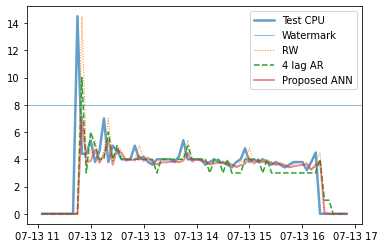

In [94]:
test_index = original[train_size:].index

#labs = ['12:00','12:30','13:00','13:30','14:00','14:30','15:00','15:30','16:00']
fig,ax = plt.subplots()
#ax.set_xticklabels(labs)
#ax.set_ylim(0,15)

# imp: 0,50 200,250 300,350 750,800 870,900 1250,1300 1570,1620 1860,1930
start = 1860
end = 1930
_ = ax.plot(pd.Series(Y_test[start:end],index = test_index[start:end]),linewidth=2.5,label='Test CPU',alpha=0.7)
_ = ax.axhline(y=SCALE_UP_WATER_MARK, linewidth=0.5,label='Watermark')
_ = ax.plot(pd.Series(rw_forecast[start:end],index = test_index[start:end]),linewidth=1,linestyle='dotted',label = 'RW')
#_ = ax.plot(pd.Series(arima_forecast[start:end] ,index = test_index[start:end]),linewidth=1.5,linestyle='dashed',label = 'Exog ARIMA (3,1,6) ')
_ = ax.plot(pd.Series(ar_forecast[start:end] ,index = test_index[start:end]),linewidth=1.5,linestyle='dashed',label = '4 lag AR')
_ = ax.plot(pd.Series(ann_forecast[start:end] ,index = test_index[start:end]),linewidth=2,alpha=0.5, label = 'Proposed ANN')

plt.legend()#loc='upper left'

plt.show()

# CPU signal vs smoothed signal

In [24]:
sample_start_date = '2020-06-18T11:30:00'
sample_end_date = '2020-06-18T17:00:00'


sample_set = (original.index > np.datetime64(sample_start_date)) & (original.index < np.datetime64(sample_end_date))
sample_index = original.index[sample_set]

In [25]:
scaled_diskwrite = percentage_scaler(df.diskwrite)
scaled_diskread = percentage_scaler(df.diskread)

In [26]:
original_sample = original[sample_set]
smoothed_sample = df['smooth_CPU'][sample_set]

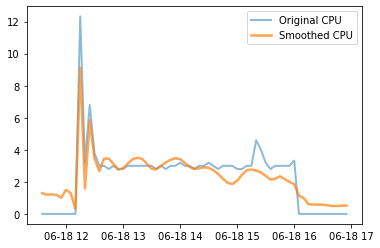

In [27]:
fig,ax = plt.subplots()

_ = ax.plot(pd.Series(original_sample,index = sample_index),linewidth=2,label='Original CPU',alpha=0.5)
_ = ax.plot(pd.Series(smoothed_sample ,index = sample_index),linewidth=2.5,alpha=0.7, label = 'Smoothed CPU')

plt.legend(loc='upper right')

plt.show()

# CPU vs Diskwrites

In [28]:
sample_writes = df.diskwrite[sample_set]

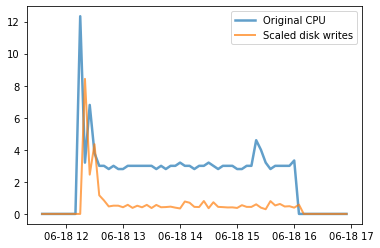

In [29]:
fig,ax = plt.subplots()

_ = ax.plot(pd.Series(original_sample,index = sample_index),linewidth=2.5,label='Original CPU',alpha=0.7)
_ = ax.plot(pd.Series(sample_writes ,index = sample_index),linewidth=2,alpha=0.7, label = 'Scaled disk writes')

plt.legend(loc='upper right')

plt.show()

# CPU vs disk read

In [30]:
sample_reads = df.diskread[sample_set]

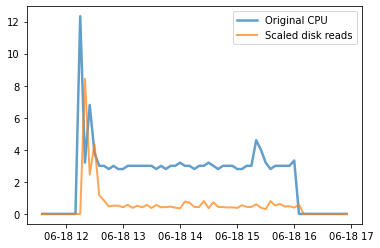

In [31]:
fig,ax = plt.subplots()

_ = ax.plot(pd.Series(original_sample,index = sample_index),linewidth=2.5,label='Original CPU',alpha=0.7)
_ = ax.plot(pd.Series(sample_writes ,index = sample_index),linewidth=2,alpha=0.7, label = 'Scaled disk reads')

plt.legend(loc='upper right')

plt.show()